## 0. Downloading datasets and installing packages

In [0]:
!git clone git://github.com/KenLauLab/pCreode

Cloning into 'pCreode'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 774 (delta 64), reused 46 (delta 18), pack-reused 648
Receiving objects: 100% (774/774), 48.88 MiB | 9.29 MiB/s, done.
Resolving deltas: 100% (379/379), done.


In [0]:
!pip install scanpy #installing scanpy, general use library for organizing and processing count matrices

     |████████████████████████████████| 6.5MB 2.4MB/s 
     |████████████████████████████████| 2.9MB 32.1MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


In [0]:
!pip install pCreode/. #installing pcreode, our trajectory inference algorithm, Herring et al. 2018, (https://www.sciencedirect.com/science/article/pii/S2405471217304490)

Processing ./pCreode
     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 3.2MB 47.2MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
  Created wheel for pcreode: filename=pcreode-2.2.0-cp36-none-any.whl size=23913 sha256=f485a4f678773809d8d5cdb73d1956d0f9c3bc42f27596a92d40eb4563ca3ef5
  Stored in directory: /tmp/pip-ephem-wheel-cache-i7mgpt0q/wheels/be/15/2f/bbf1aed27ffebb007b591029165c280cf1fbca1af10dcb482c
  Created wheel for nvr: filename=NVR-0.0.6-cp36-none-any.whl size=4537 sha256=534a408b1255080fd25611354d42e0eab7b679b1d97528426926af2963d5933c
  Stored in directory: /root/.cache/pip/wheels/7a/d5/a3/32ab59344f5d4744f96fc95bcd9d14f73a441f522f7d074f05
  Created wheel for cairocffi: filename=cairocffi-1.1.0-cp36-none-any.whl size=88590 sha256=4b0f210a4c565f08f8579b448ebc68dcce4f525e7f82b199b23243f50d438558
  Stored in directory: /root/.cache/pip/wheels/11/5e/47/167d9dfd5fa5850dd0cd3db80afe6db46e620edec3419dce5a
Successfully built p

In [0]:
!pip install python-igraph==0.7.1.post6 #software library for graph theoretic representations of the data

     |████████████████████████████████| 378kB 2.9MB/s 


## 1. Loading installed python packages and datasets into the environment

In [0]:
import scanpy as sc #import scanpy
import pandas as pd #pandas 
import numpy as np #import numpy
import pcreode #import pcreode
import matplotlib.pylab as plt #import matplotlib 

In [0]:
myeloid_adata = sc.read_h5ad("pCreode/data/Myeloid_Raw_Normalized_Transformed.h5ad")
myeloid_adata

AnnData object with n_obs × n_vars = 4423 × 14955 

The pCreode algorithm maps the topology of the cellular coordinates in PCA transformed gene expression space.

![alt text](https://raw.githubusercontent.com/bobchen1701/SCA_Course_SP_2020/master/Screen%20Shot%202020-03-03%20at%205.29.13%20PM.png)

## 2. Preprocessing (step 1+2)

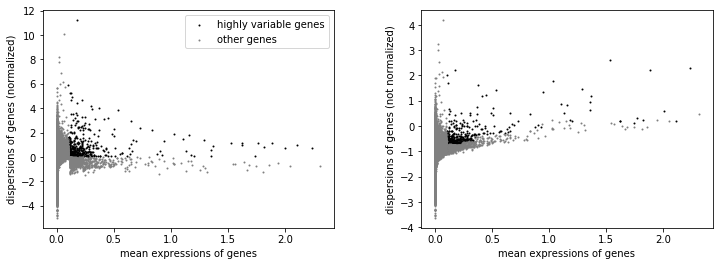

In [0]:
#we feature select using highly_variable_genes to maximize the signal to noise ratio
sc.pp.highly_variable_genes(myeloid_adata,min_mean=0.1,max_mean=None,min_disp=0,max_disp=None)
sc.pl.highly_variable_genes(myeloid_adata)

In [0]:
myeloid_adata.var.highly_variable.sum()

558

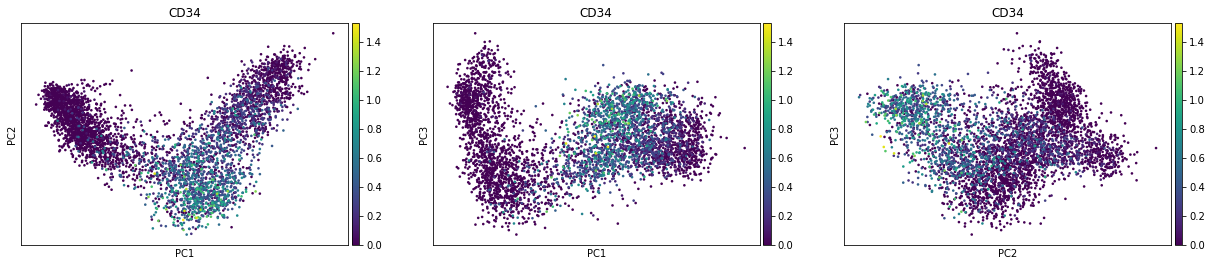

In [0]:
#we can perform the pca with the top 558 most highly variable genes. this allows us to visualize the variation in the gene expression of single cells in a more interpretable number of dimensions
sc.pp.pca(myeloid_adata, n_comps = 20,use_highly_variable=True)
sc.pl.pca(myeloid_adata,components=['1,2','1,3','2,3'],color='CD34')

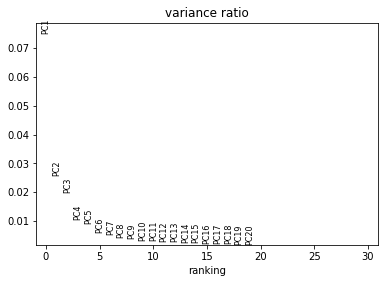

In [0]:
sc.pl.pca_variance_ratio(myeloid_adata) #note that the vast majority of the variance in the data is captured by the first 10 principal components or so

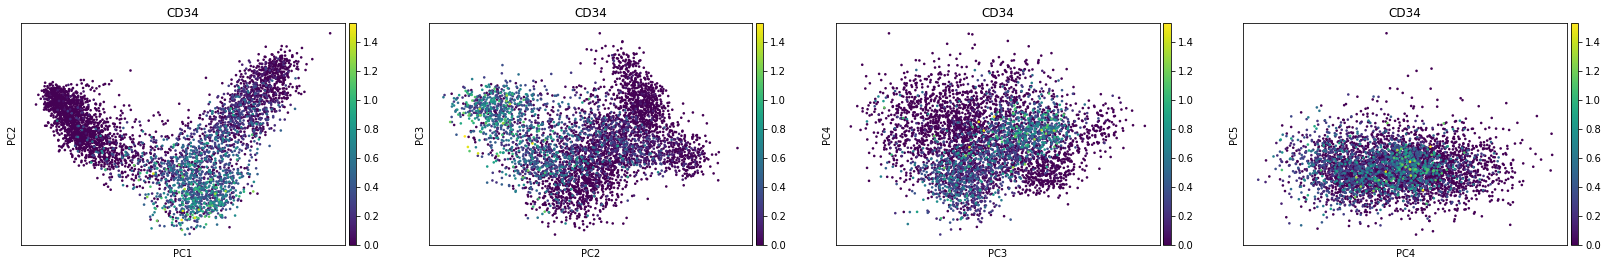

In [0]:
sc.pl.pca(myeloid_adata,components=['1,2','2,3','3,4','4,5'],color='CD34')

In [0]:
pca_reduced_data = myeloid_adata.obsm['X_pca'][:,:3] 
#Here we simply subset the myeloid_adata PCA observation matrix to its first 3 components using standard array subsetting conventions

## 2. Density-weighted K-nearest neighbors graph parameter optimization and construction (Step 1+2)

We must first determine the radius in which to draw edges between nodes in this graph 

best guess starting radius = 0.7309644222259521


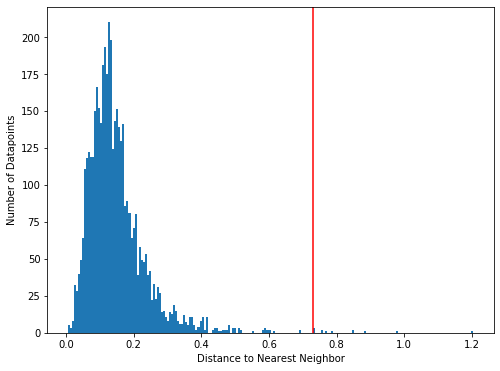

In [0]:
dens = pcreode.Density( pca_reduced_data ) #input the 3 principal components 
best_guess = dens.nearest_neighbor_hist() #look at the distribution of distances between cells in that space
#best automatic guess is 0.73

Example of a radius set too low

calculating densities for datapoints: 0 -> 4422
****Always check density overlay for radius fit****


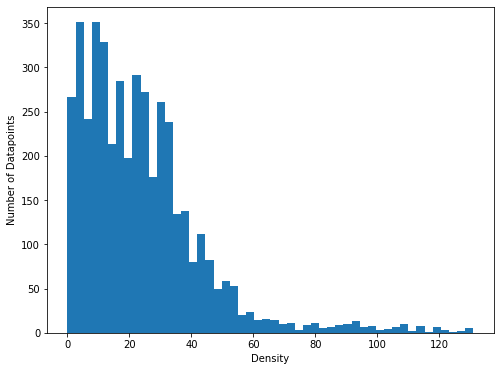

In [0]:
myeloid_adata.obs['Density'] = dens.get_density( radius=0.4) #set myeloid_adata 'Density' observation, or the number of neighbors which fall within the radius search constraints
dens.density_hist( n_bins=50) #the distribution is skewed towards a low density graph, which is unable to incorporate more global similarities

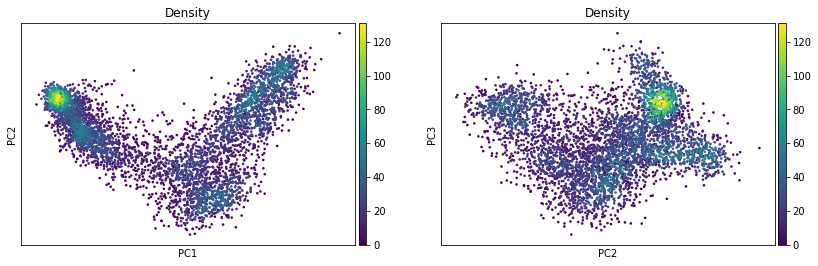

In [0]:
sc.pl.pca(myeloid_adata,components=['1,2','2,3'],color = 'Density') #overlay each cell's Density value onto a three principal components
#there are regions in this overlay that are very low density, which is undesireable

Example of radius set too high

calculating densities for datapoints: 0 -> 4422
****Always check density overlay for radius fit****


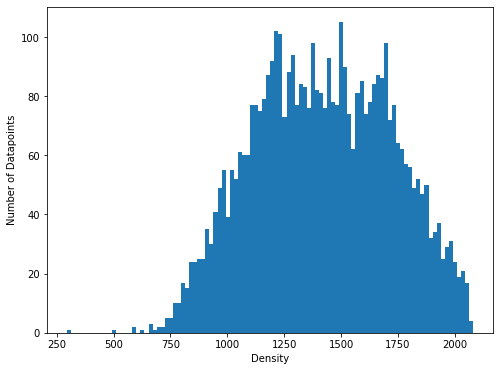

In [0]:
myeloid_adata.obs['Density'] = dens.get_density( radius=3) #set myeloid_adata 'Density' observation
dens.density_hist( n_bins=100)

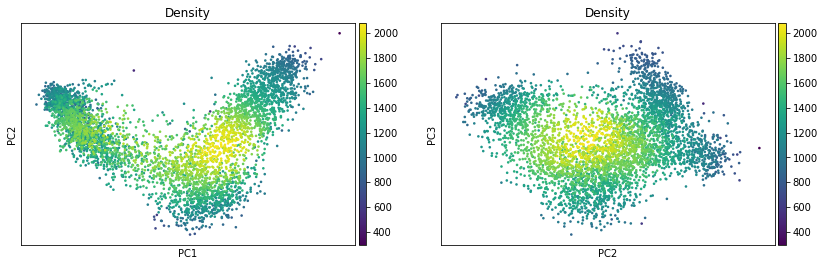

In [0]:
sc.pl.pca(myeloid_adata,components=['1,2','2,3'],color = 'Density')  #overlay each cell's Density value onto a three principal components
#the density seems to become an overlay that doesn't consider the local structures and becomes more of an overall representation of where the "center" of the graph is

Example of "just right" radius

calculating densities for datapoints: 0 -> 4422
****Always check density overlay for radius fit****


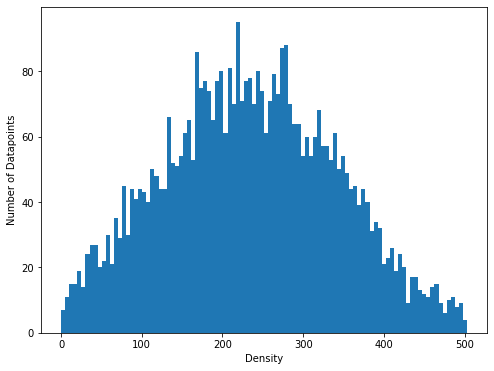

In [0]:
myeloid_adata.obs['Density'] = dens.get_density( radius=1) #set myeloid_adata 'Density' observation
dens.density_hist( n_bins=100)

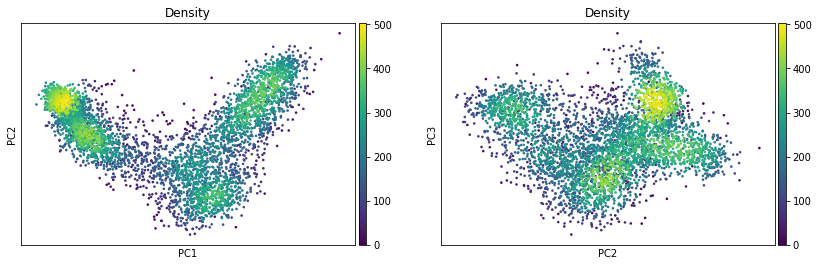

In [0]:
sc.pl.pca(myeloid_adata,components=['1,2','2,3'],color = 'Density')  #overlay each cell's Density value onto a three principal components
#this is pretty good since theres a fairly symmetric distribution of densities

## 3. Downsampling and noise reduction (Step 1+2)

Here we determine the values used for the noise and target parameters.

In [0]:
noise = 8 #noise cutoff based on density value
target = 20 #target downsampling proportion

In [0]:
downed, downed_ind = pcreode.Down_Sample( pca_reduced_data, myeloid_adata.obs['Density'], noise, target)

Number of data points in downsample = 1983


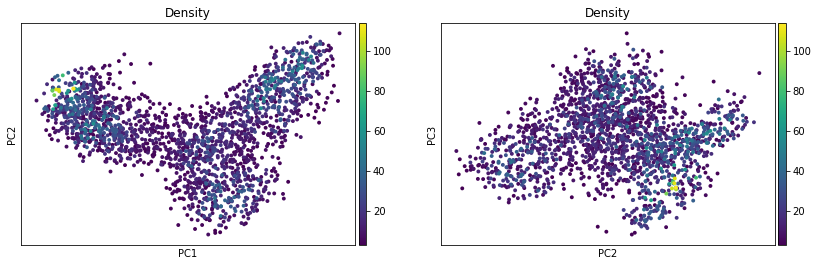

In [0]:
sc.pl.pca(myeloid_adata[downed_ind],components=['1,2','2,3'],color = 'Density')  #density downsampled

## 4. Running pCreode using the above determined parameters and PCA (Step 2,3,4,5,6)

In [0]:
file_path = "Output/"

In [0]:
!mkdir Output

mkdir: cannot create directory ‘Output’: File exists


In [0]:
out_graph, out_ids = pcreode.pCreode( data=pca_reduced_data, density=np.array(myeloid_adata.obs['Density']), noise=noise, 
                                      target=target, file_path=file_path, num_runs=3)

Performing 3 independent runs, may take some time
Number of data points in downsample = 2053
Constructing density kNN
finding endstates
Number of endstates found -> 6
hierarchical placing
consensus aligning
saving files for run_num 1
Number of data points in downsample = 2019
Constructing density kNN
finding endstates
Number of endstates found -> 4
hierarchical placing
consensus aligning
saving files for run_num 2
Number of data points in downsample = 1938
Constructing density kNN
finding endstates
Number of endstates found -> 6
hierarchical placing
consensus aligning
saving files for run_num 3


## 5. Scoring each pCreode graph (Step 7)

In [0]:
graph_ranks = pcreode.pCreode_Scoring( data=pca_reduced_data, file_path=file_path, num_graphs=3)

scoring graph 1
scoring graph 2
Most representative graph IDs from first to worst [1 2 0]


In [0]:
analysis = pcreode.Analysis( file_path=file_path, graph_id=graph_ranks[0], data=pca_reduced_data, density=np.array(myeloid_adata.obs['Density']), noise=noise)

In [0]:
seed=5656

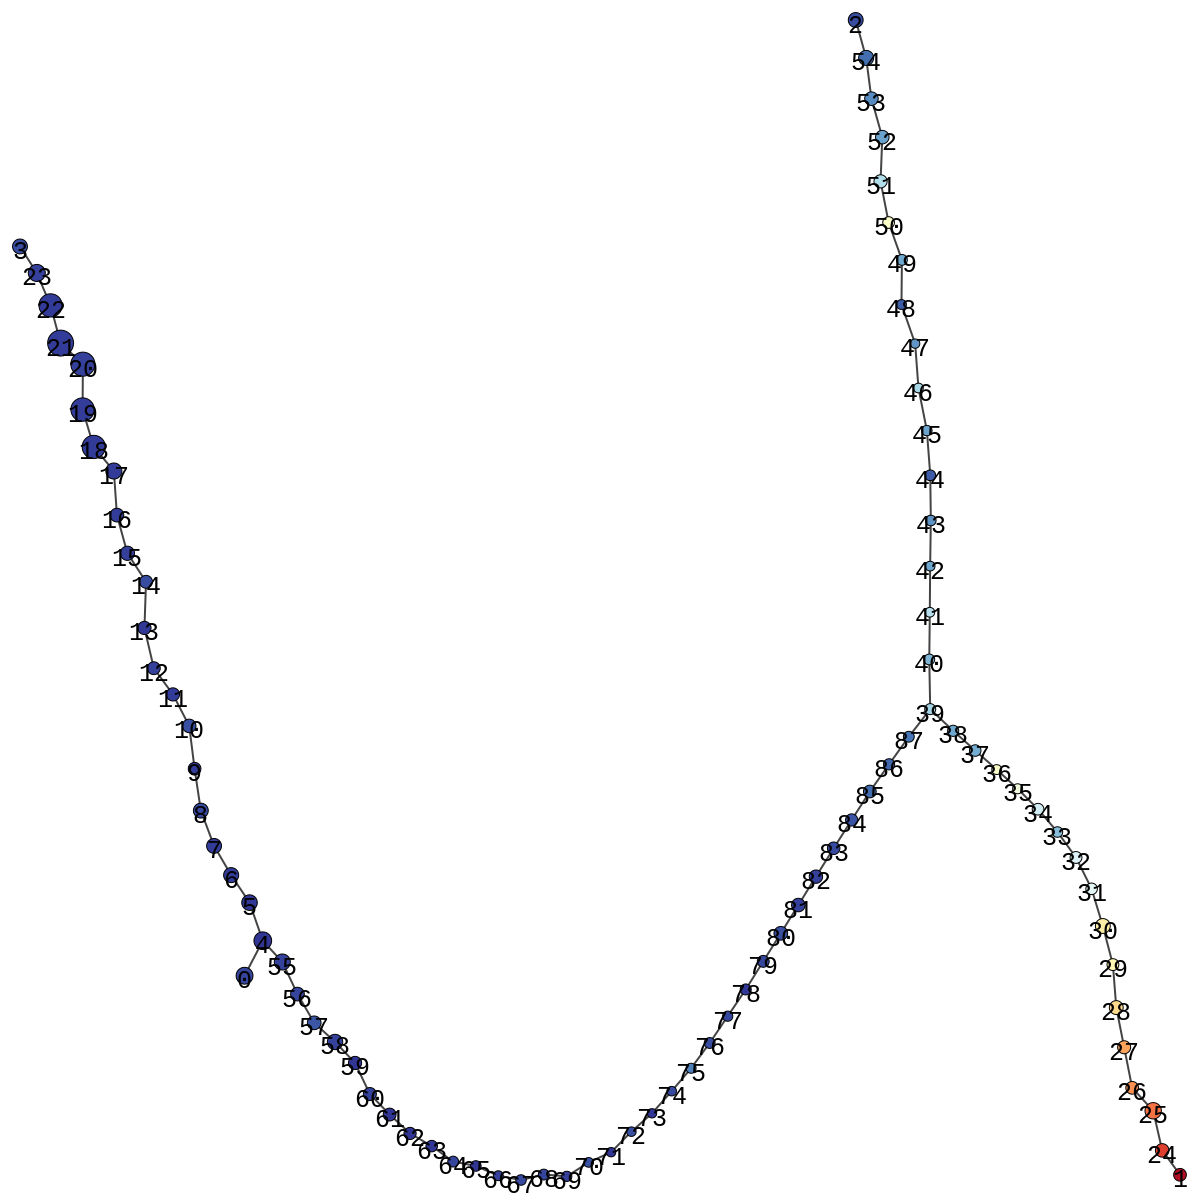

In [0]:
analysis.plot_save_graph( seed=seed, overlay=pd.Series(myeloid_adata.obs_vector('ELANE')), file_out='ELANE', upper_range=1.25,node_label_size=25)

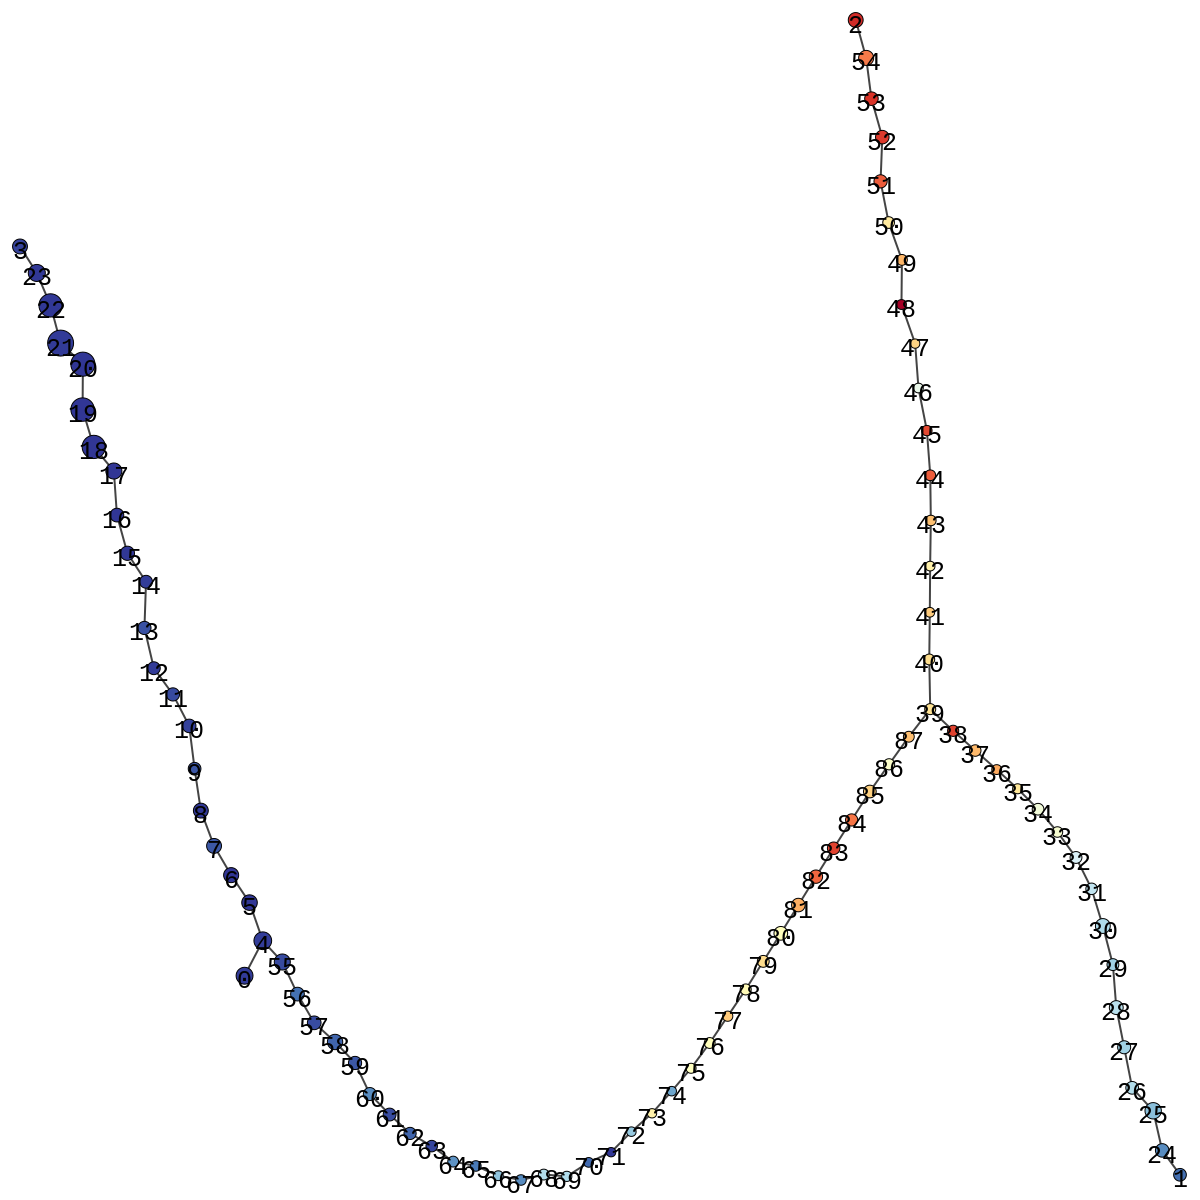

In [0]:
analysis.plot_save_graph( seed=seed, overlay=pd.Series(myeloid_adata.obs_vector('CD34')), file_out='CD34', upper_range=3,node_label_size=25)

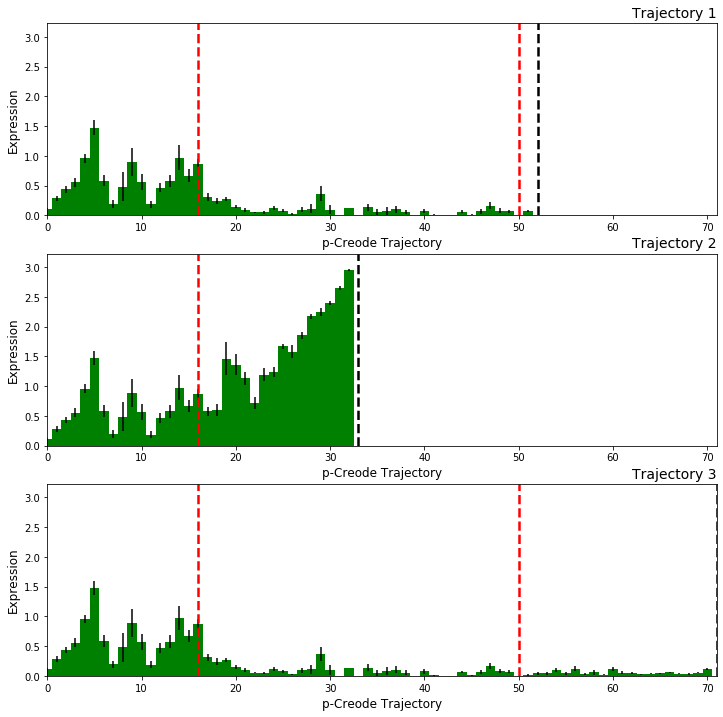

In [0]:
analysis.plot_analyte_dynamics( pd.Series(myeloid_adata.obs_vector('ELANE')), 2) #2 is the root due to prior knowledge of cd34 expression